<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "CNU"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/BrainStructures/CNU/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


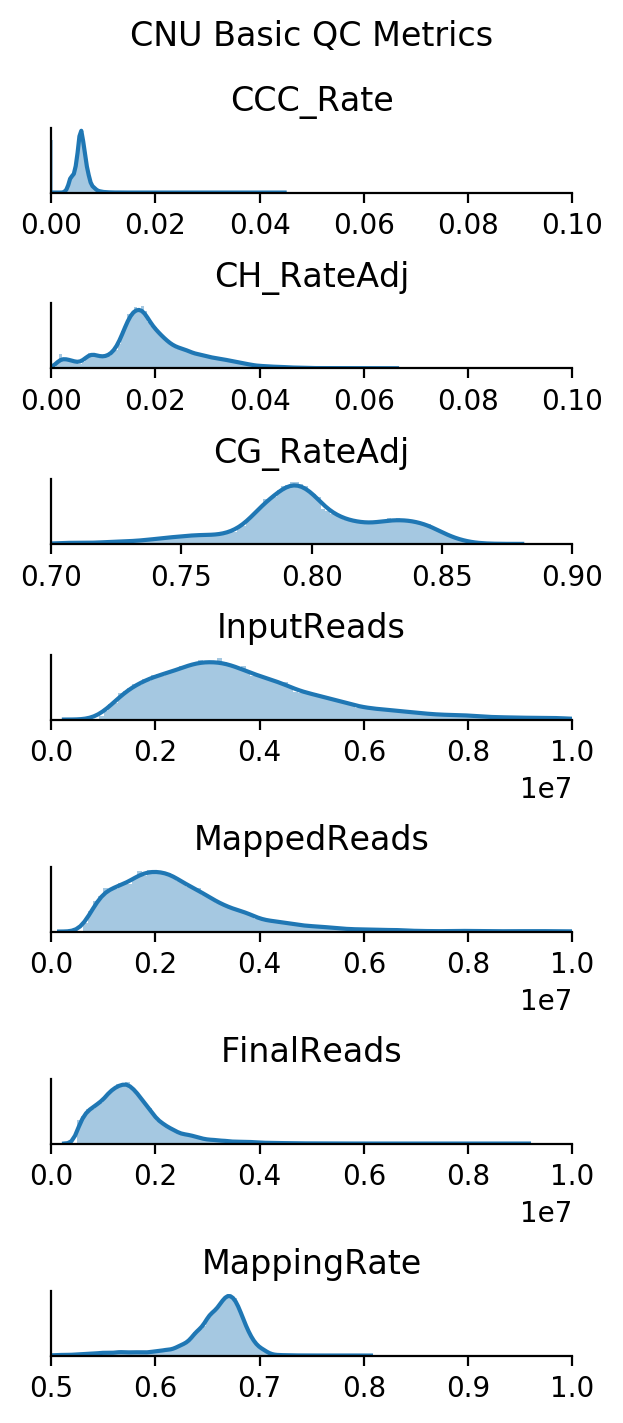

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

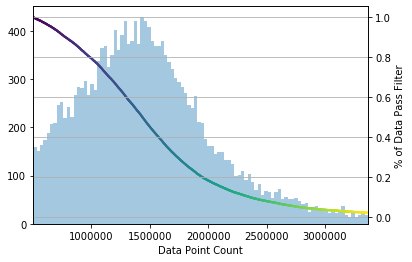

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 19076/19076 (100.0%)
CG_RateAdj passed 19076/19076 (100.0%)
CH_RateAdj passed 19076/19076 (100.0%)
FinalReads passed 19076/19076 (100.0%)
MappingRate passed 19076/19076 (100.0%)
Overall passed 19076/19076 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171214 1091
171219 1422
180109 957
180110 1218
180111 538
180405 1129
180724 180
180806 711
180911 1196
180917 1011
180925 1349
181015 1350
181016 1266
181204 956
181206 1235
181218 754
181220 1479
190207 1234


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 2144 558.3%
ad002 2406 626.6%
ad004 2391 622.7%
ad006 2391 622.7%
ad007 2427 632.0%
ad008 2483 646.6%
ad010 2416 629.2%
ad012 2418 629.7%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
3F_M_0,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.003520,0.743450,0.742540,0.006190,0.002680,2112242.0,5701272,3354313.0,3F,...,-3.325884,7.178353,15.103774,-31.979497,ASC str-hpf,9.948091,1.851987,-1.970187,-23.891070,True
3F_M_10,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.003730,0.752820,0.751890,0.007490,0.003770,1029642.0,2738028,1604013.0,3F,...,-5.005371,7.696533,4.263082,-29.664896,ASC str-hpf,7.221619,3.264130,6.206841,-11.464039,True
3F_M_100,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.005690,0.775910,0.774630,0.022240,0.016640,691324.0,1949012,1050335.0,3F,...,-3.976195,-17.845863,31.267591,-16.043350,MSN-D1 Ntn1,-13.285547,1.432165,26.794592,7.700932,True
3F_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.005780,0.788280,0.787050,0.021990,0.016300,933132.0,2968672,1722534.0,3F,...,7.658859,-9.563505,23.567632,42.304529,MSN-D2 Col14a1,0.846165,1.977796,11.020996,9.794150,True
3F_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.006990,0.781110,0.779570,0.031350,0.024530,1225252.0,3672260,2201178.0,3F,...,2.758455,5.428421,25.121897,-30.549951,OLF-Exc Cdh9,7.541663,-13.036026,-30.756167,-25.693932,True
3F_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.003930,0.759300,0.758350,0.007430,0.003510,1170268.0,3103414,1864328.0,3F,...,-4.917071,8.730023,4.274550,-26.503950,ASC str-hpf,8.215447,3.894939,8.232348,-14.420447,True
3F_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.005380,0.798790,0.797700,0.019730,0.014430,529434.0,1466392,826929.0,3F,...,1.917367,0.089946,-25.606517,39.628993,Foxp2 Dchs2,-0.126366,-5.907055,-5.933428,4.273153,True
3F_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.005240,0.767140,0.765910,0.018440,0.013270,689777.0,1970260,1098602.0,3F,...,3.754290,-2.896861,-5.919439,48.476965,Foxp2 Trpc7,-1.238268,2.958041,19.296017,-14.471625,True
3F_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.007960,0.825160,0.823760,0.041060,0.033370,894683.0,2472696,1388577.0,3F,...,-12.300880,0.427385,-16.003835,21.676615,PAL-Inh Meis2,9.310797,13.772326,27.529009,14.368234,True
3F_M_1006,/gale/raidix/rdx-4/CEMBA_RS1/3F/CEMBA180109_3F...,0.006210,0.791730,0.790430,0.025960,0.019870,1010555.0,2995390,1762413.0,3F,...,-0.624665,-16.972858,21.817673,-11.684034,D1L-Fstl4 Grm3,13.396517,-7.317649,-27.546182,-9.956064,True
